In [1]:
import os
from itertools import product

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
from scipy import special as sp
import SimpleITK as sitk

from src.models.layers_faster import SHConv3DRadial, BSHConv3D, SSHConv3D
from src.models.utils import config_gpu
# from src.models.models import ResidualSLRILayer3D, ResidualBLRILayer3D

%matplotlib inline

In [2]:
# image_sitk = sitk.ReadImage("/home/vscode/python_wkspce/petct-seg/data/processed/CHGJ074_ct.nii.gz")

In [3]:
config_gpu("0", memory_limit=4)

1 Physical GPUs, 1 Logical GPUs


In [4]:
layer = SSHConv3D(1, 3, max_degree=5, padding="valid", initializer=tf.keras.initializers.Constant(value=1.0),  project=False)

2022-10-08 18:38:26,891 - src.models.layers_faster - INFO - Initializing SSHConv3D layer with streams: 1
2022-10-08 18:38:27,493 - src.models.layers_faster - INFO - Initializing SSHConv3D layer with streams: 1 - done


In [5]:
def rotate_3d(image, angle1, angle2, angle3):
    image = np.squeeze(image)
    image = rotate(image, -angle1, axes=(0, 1), reshape=False)
    image = rotate(image, angle2, axes=(1, 2), reshape=False)
    image = rotate(image, -angle3, axes=(0, 1), reshape=False)
    return image


def inv_rotate_3d(image, angle1, angle2, angle3):
    image = np.squeeze(image)
    image = rotate(image, angle3, axes=(0, 1), reshape=False)
    image = rotate(image, -angle2, axes=(1, 2), reshape=False)
    image = rotate(image, angle1, axes=(0, 1), reshape=False)
    return image

In [6]:
layer.indices[15]

IndexError: list index out of range

In [7]:
layer.indices_inverse[(1,2,3)]
# layer.indices_inverse[1]

TypeError: list indices must be integers or slices, not tuple

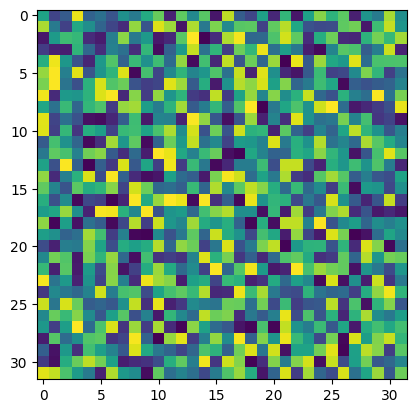

In [8]:
# image = np.transpose(sitk.GetArrayFromImage(image_sitk), (2, 1, 0))
# image = image[60:92, 60:92, 70:102]
image = np.random.rand(32, 32, 32)
plt.imshow(image[:, :, 15])

In [9]:
# image = np.random.rand(image.shape[0], image.shape[1], image.shape[2])

In [10]:
angle1, angle2, angle3 = 90, 90, 0
axes = (2, 1)
# image = np.random.uniform(size=(32, 32, 32))
image_rotated = rotate_3d(image, angle1, angle2, angle3)


In [11]:
image.shape

(32, 32, 32)

In [12]:
output = layer(image[np.newaxis, :, :, :, np.newaxis])
output_rotated = layer(image_rotated[np.newaxis, :, :, :, np.newaxis])

2022-10-08 18:38:35,476 - src.models.layers_faster - INFO - SHConv3D: real filters dtype cast to: <dtype: 'float32'>
2022-10-08 18:38:36,847 - src.models.layers_faster - INFO - SHConv3D: real filters dtype cast to: <dtype: 'float32'>


In [13]:
def check_output_diff(output):
    for k1 in range(output.shape[-1]):
        if np.sum(np.abs(output[...,k1]))==0:
            print(f"map {layer.indices[k1]} is zero")


In [14]:
output.shape

TensorShape([1, 30, 30, 30, 6])

In [15]:
check_output_diff(output)

In [16]:
output.shape

TensorShape([1, 30, 30, 30, 6])

In [17]:
s = np.max(np.real(output), axis=(0,1,2,3))
for i in range(s.shape[-1]):
    print(f"{layer.indices[i]}: {s[i]}")

0: 2.5665907859802246
1: 0.42330679297447205
2: 0.3180272579193115
3: 0.3058669865131378
4: 0.4878573417663574
5: 0.3078243136405945


In [18]:
# s = np.sum(np.imag(output), axis=(0,1,2,3))
# for i in range(s.shape[-1]):
#     print(f"{layer.indices[i]}: {s[i]}")

In [19]:
# f_ind = layer.indices_inverse[(1, 1,2)]
# f_ind = layer.indices_inverse[(2, 3, 5)]
f_ind = 3
fmap = output[0, :, :, :, f_ind]
fmap_rotated = output_rotated[0, :, :, :, f_ind]
fmap_unrotated = inv_rotate_3d(fmap_rotated, angle1, angle2, angle3)
# fmap_unrotated = rotate(fmap_rotated, -90, axes=(0, 1), reshape=False)

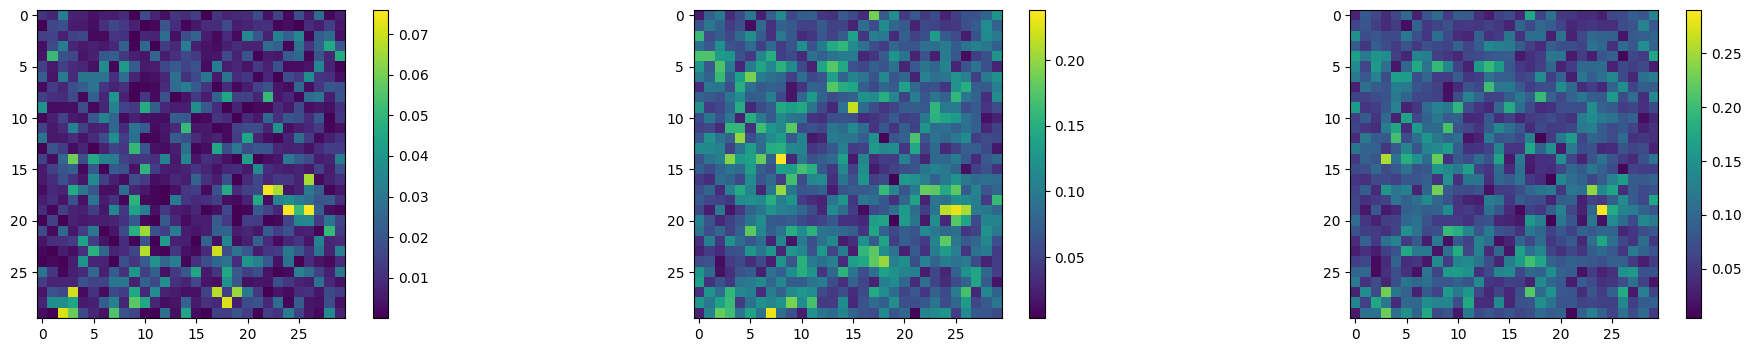

In [20]:
s = 15
difference = fmap - fmap_unrotated
plt.figure(figsize=(24, 4))
plt.subplot(131)
plt.imshow(np.abs(difference[:, :, s]))
plt.colorbar()
plt.subplot(132)
plt.imshow(np.abs(fmap[:, :, s]))
plt.colorbar()
plt.subplot(133)
plt.imshow(np.abs(fmap_unrotated[:, :, s]))
plt.colorbar()

In [21]:
np.sum(fmap[...])

2144.3684

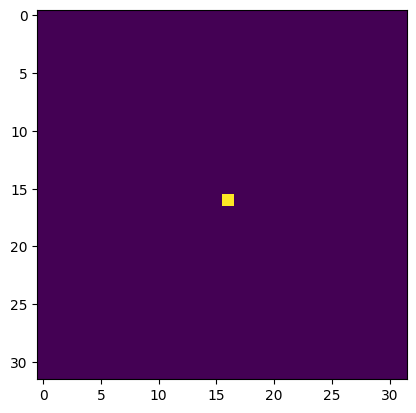

In [22]:
kernel_size = 32
dirac = np.zeros((1, kernel_size, kernel_size, kernel_size, 1))
dirac[0, kernel_size // 2, kernel_size // 2, kernel_size // 2, 0] = 1
plt.imshow(dirac[0, :, :, kernel_size//2, 0])

In [23]:
impulse_response = layer(dirac)

2022-10-08 18:38:50,784 - src.models.layers_faster - INFO - SHConv3D: real filters dtype cast to: <dtype: 'float32'>


In [24]:
layer.indices[7]

IndexError: list index out of range

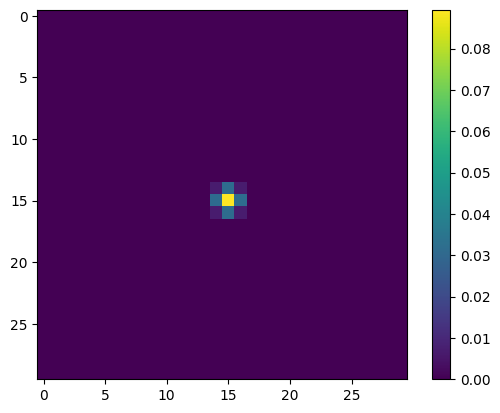

In [25]:
plt.imshow(impulse_response[0, :, :, kernel_size // 2, 1])
plt.colorbar()

In [26]:
impulse_response.shape

TensorShape([1, 30, 30, 30, 6])

In [ ]:
yo = layer.conv_sh.atoms.numpy()


In [ ]:
yo.shape

In [ ]:
plt.imshow(np.imag(yo[:, :, 1, 0, 11]))
plt.colorbar()